# Comparing Counts using the Weighted Displacement Difference Test

These show examples of the Weighted Displacement Difference test. Also shows the e-test for differences in simple Poisson counts.

Krishnamoorthy, K., & Thomson, J. (2004). A more powerful test for comparing two Poisson means. [*Journal of Statistical Planning and Inference*, 119(1), 23-35](https://www.sciencedirect.com/science/article/pii/S0378375802004081). ([Online PDF](https://userweb.ucs.louisiana.edu/~kxk4695/JSPI-04.pdf))

Wheeler, A. P., & Ratcliffe, J. H. (2018). A simple weighted displacement difference test to evaluate place based crime interventions. [*Crime Science*, 7(1), 11](https://link.springer.com/article/10.1186/s40163-018-0085-5). (Crime Science is an open journal)

In [1]:
from crimepy.wdd import etest, wdd, wdd_harm, cum_wdd
from crimepy.cdcplot import plt
import pandas as pd
import numpy as np
from scipy.stats import norm

print('Example use for the WDD (no spillover)')
print('120 to 100 in treated')
print('130 to 150 in control')
res = wdd((130,150),(120,100))
print(f'Total WDD {res.Est_Total:.0f} ({res.SE_Total:.1f}) and 90% CI [{res.LowCI:.1f} to {res.HighCI:.1f}]')
print('')

print('Example use for the WDD (with spillover)')
print('120 to 100 in treated')
print('130 to 150 in control')
print('40 to 25 in displacement')
print('30 to 25 in control')
res = wdd((130,150),(120,100),(30,25),(40,25))
print(f'Total WDD {res.Est_Total:.0f} ({res.SE_Total:.1f}) and 90% CI [{res.LowCI:.1f} to {res.HighCI:.1f}]')
print('')

print('Example use for the WDD (rates per time)')
print('100 to 20 in treated')
print('200 to 100 in control')
print('time weights 2 years prior, 1 year post (so same as 50 to 20 vs 100 to 100)')
res = wdd((200,100),(100,20),time_weights=[2,1])
print(f'Total WDD {res.Est_Total:.0f} ({res.SE_Total:.1f}) and 90% CI [{res.LowCI:.1f} to {res.HighCI:.1f}]')
print('')

print('Example use for the WDD (rates per area)')
print('200 to 100 in treated')
print('400 to 200 in control')
print('40 to 20 in displacement')
print('80 to 40 in control')
print('Area weights treated = 1, control = 2, displacement = 1, displacement control = 2')
res = wdd((400,200),(200,100),(80,40),(40,20),area_weights=(2,1,2,1))
print(f'Total WDD {res.Est_Total:.0f} ({res.SE_Total:.1f}) and 90% CI [{res.LowCI:.1f} to {res.HighCI:.1f}]')
print('These are intended to be exactly equal')


Example use for the WDD (no spillover)
120 to 100 in treated
130 to 150 in control
Total WDD -40 (22.4) and 90% CI [-76.8 to -3.2]

Example use for the WDD (with spillover)
120 to 100 in treated
130 to 150 in control
40 to 25 in displacement
30 to 25 in control
Total WDD -50 (24.9) and 90% CI [-91.0 to -9.0]

Example use for the WDD (rates per time)
100 to 20 in treated
200 to 100 in control
time weights 2 years prior, 1 year post (so same as 50 to 20 vs 100 to 100)
Total WDD -30 (14.0) and 90% CI [-53.0 to -7.0]

Example use for the WDD (rates per area)
200 to 100 in treated
400 to 200 in control
40 to 20 in displacement
80 to 40 in control
Area weights treated = 1, control = 2, displacement = 1, displacement control = 2
Total WDD 0 (23.2) and 90% CI [-38.2 to 38.2]
These are intended to be exactly equal


In [2]:
# Example of Combining Multiple WDD estimates together
mv = wdd((133,91),(130,74), silent=True)
th = wdd((388,305),(327,202), silent=True)
bu = wdd((148,97),(398,190), silent=True)
rob = wdd((86,64),(144,92), silent=True)
ass = wdd((94,67),(183,96), silent=True)
tot = pd.DataFrame([mv,th,bu,rob,ass],index=['mv','th','bu','rob','ass'])
tot['weight'] = [3,2,5,7,10]
print(tot) # combined dataframe

# resulting WDD combined estimate with harm weights
wdd_harm(tot['Est_Total'], tot['SE_Total'],tot['weight'],alpha=0.05)

     Est_Local   SE_Local  Est_Displace  SE_Displace  Est_Total   SE_Total  \
mv       -14.0  20.688161           0.0          0.0      -14.0  20.688161   
th       -42.0  34.957117           0.0          0.0      -42.0  34.957117   
bu      -157.0  28.861739           0.0          0.0     -157.0  28.861739   
rob      -30.0  19.646883           0.0          0.0      -30.0  19.646883   
ass      -60.0  20.976177           0.0          0.0      -60.0  20.976177   

            Z       LowCI      HighCI  weight  
mv  -0.676716  -48.028996   20.028996       3  
th  -1.201472  -99.499340   15.499340       2  
bu  -5.439728 -204.473337 -109.526663       5  
rob -1.526960  -62.316246    2.316246       7  
ass -2.860388  -94.502741  -25.497259      10  


WDDHarmResults(HarmEst=np.float64(-1721.0), SE_HarmEst=304.1036007678962, Z=np.float64(-5.659255581500118), LowCI=np.float64(-2317.0321050740235), HighCI=np.float64(-1124.9678949259765))

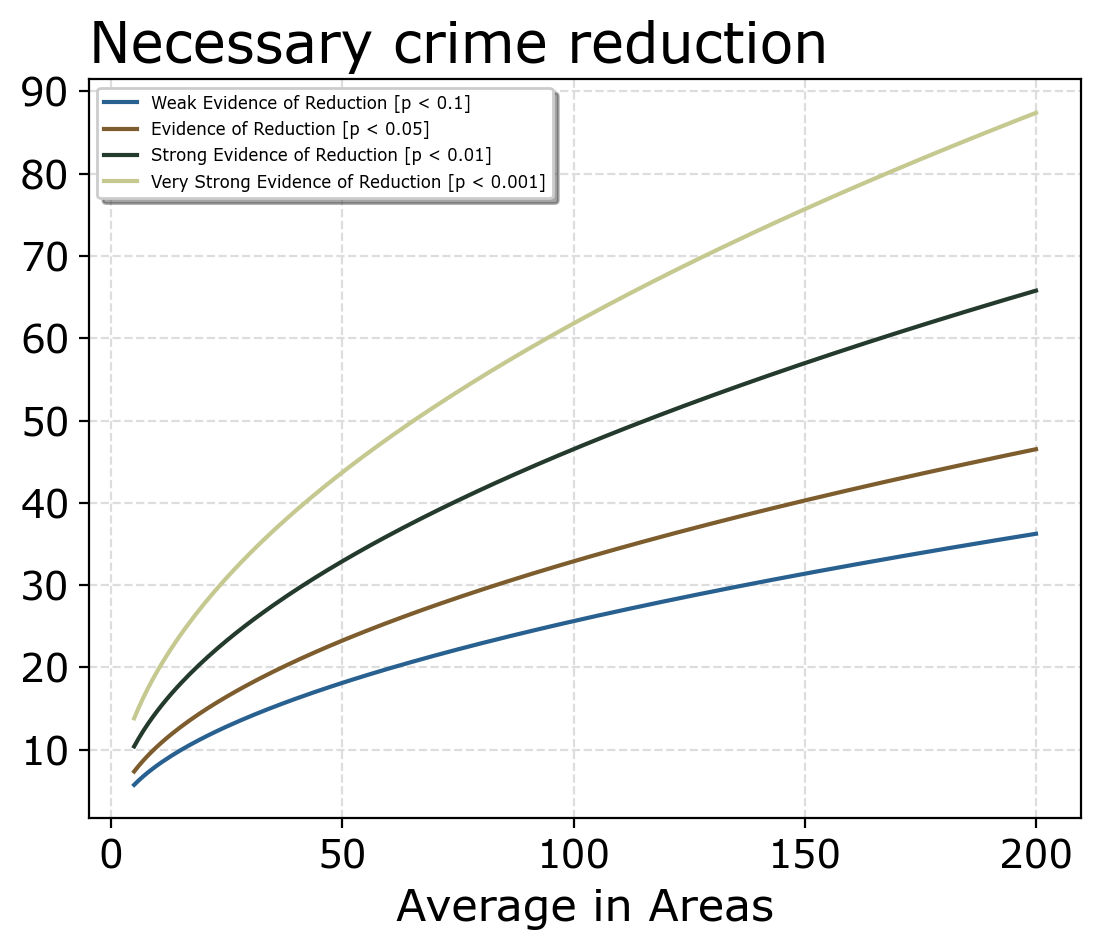

In [3]:
# Chart for planning power
# This shows if you have 50 crimes on average in the areas (no displacement, just treated/control)
# you need to reduce crimes by around 25 to detect a significant difference at a p-value of 0.01

avmean = np.arange(5,201) # average mean per area
se_d = np.sqrt(avmean*8)  # standard error if using displacement
se_nd = np.sqrt(avmean*4) # standard error if no displacement
p_thresh = {'Weak Evidence of Reduction [p < 0.1]':0.1,
            'Evidence of Reduction [p < 0.05]':0.05,
            'Strong Evidence of Reduction [p < 0.01]':0.01,
            'Very Strong Evidence of Reduction [p < 0.001]':0.001}

df = pd.DataFrame(zip(avmean,se_d,se_nd),columns=['Average in Areas','SE','SE (no displacement)'])
kl = []

for k,v in p_thresh.items():
    kl.append(k)
    z = norm.ppf(1-v)
    df[k] = z*df['SE (no displacement)'] # replace with SE if you have displacement areas

ax = df[kl + ['Average in Areas']].plot(x='Average in Areas')
ax.set_title('Necessary crime reduction')
leg = ax.legend(fontsize=6)


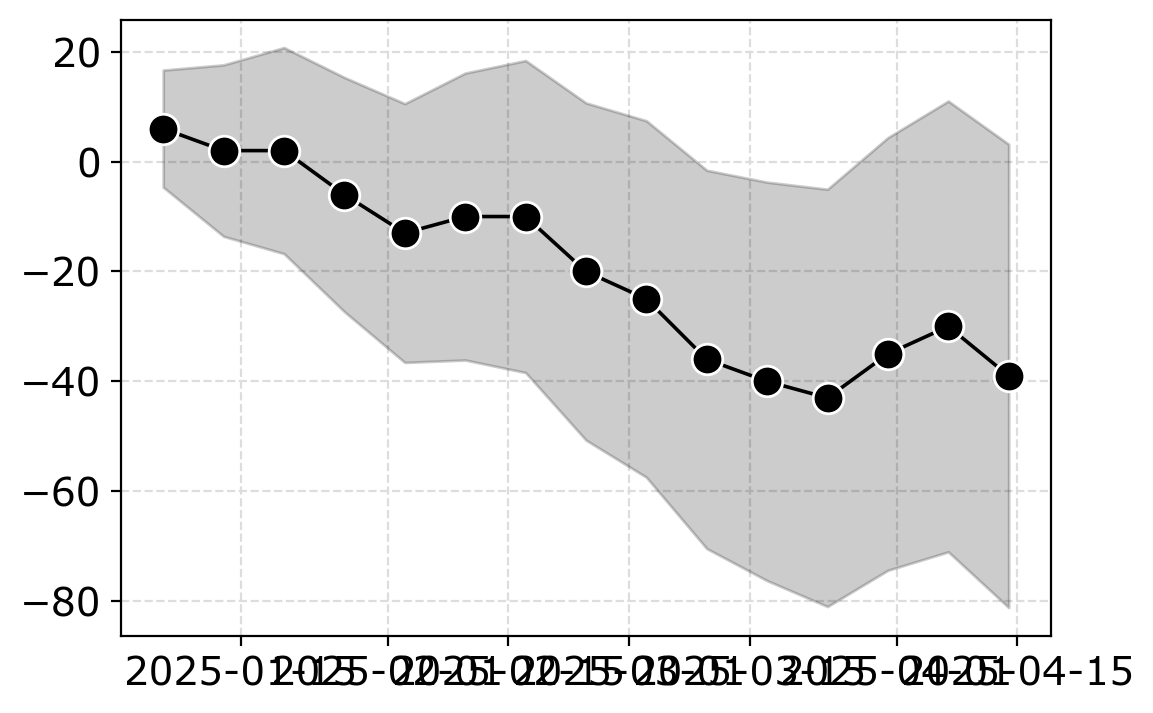

In [7]:
# Function to examine differences over time
# making simulated data

dr = pd.date_range(start='2025-01-06', periods=15, freq='7D')
np.random.seed(10)
treat = np.random.poisson(lam=20,size=dr.shape[0])
cont = np.random.poisson(lam=25,size=dr.shape[0])
df = pd.DataFrame(zip(dr,treat,cont),columns=['Week','Treated','Control'])
cum_stats = cum_wdd(df,'Treated','Control')
cum_stats['Week'] = df['Week']

cum_stats

# creating chart of the differences over time
fig, ax = plt.subplots(figsize=(6,4))
ax.fill_between(cum_stats['Week'], cum_stats['LowCI'], cum_stats['HighCI'],alpha=0.2, color='k')
ax.plot(cum_stats['Week'],cum_stats['CumDif'],c='k',linewidth=1.3,
        marker='o',markersize=11,markeredgecolor='white')


In [5]:

# SIMPLE EXAMPLE OF ETEST, comparing two Poisson counts
# directly and getting a p-value of the difference
# not recommended, but sometimes useful for a quick check

print('Compare 0 vs 3')
print(etest(0,3))

print('\nCompare 3 vs 0, it is asymmetric')
print(etest(3,0))

print('\nCompare rates 6/2 vs 3')
print(etest(6,3,2,1))

print('\nCompare counts 10 vs 5')
print(etest(10,5))

print('\nCompare rates 100/10 vs 25/5')
print(etest(100,25,10,5))

print('\nWill be just under 1 due to finite sum approx to infinite sum')
print(etest(20,20))

print('\nTests the null k1/n1 = k2/n2 + d, 15=5, default d=0')
print(etest(15,5,d=0))

print('\nTests the null k1/n1 = k2/n2 + d, here uses offset, 15 = 5 + 5')
print(etest(15,5,d=5))

Compare 0 vs 3
0.08837900945483519

Compare 3 vs 0, it is asymmetric
0.08837900945483519

Compare rates 6/2 vs 3
0.9998765901959134

Compare counts 10 vs 5
0.2061644140757639

Compare rates 100/10 vs 25/5
0.0015380662884757802

Will be just under 1 due to finite sum approx to infinite sum
0.9999999999999929

Tests the null k1/n1 = k2/n2 + d, 15=5, default d=0
0.025035114389344547

Tests the null k1/n1 = k2/n2 + d, here uses offset, 15 = 5 + 5
0.2018456684107425
